<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Aging/AgingCountersTestStandUVaBottom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and load data

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy.polynomial.polynomial as poly
import numpy as np
import scipy
from scipy.optimize import curve_fit
import statistics
import math
from datetime import datetime, timedelta
plt.rcParams.update({'figure.max_open_warning': 0})
import itertools as it

MIN_TEMP=21
MAX_TEMP=22
TIME_INDEX_CUT=4020

CS137_DECAY_RATE=0.023 # 2.3%/year

In [17]:
!pip install gdown
!gdown https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT

Downloading...
From: https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT
To: /content/ScanningData_NaturalAgingBottom.txt
100% 3.96M/3.96M [00:00<00:00, 43.6MB/s]


In [18]:
!tail ScanningData_NaturalAgingBottom.txt

	1/4/2022 3:35 PM	1	0.5790	0.6079	0.5363	0.5693	0.7771	0.8177	0.7883	0.7947	0.8018	0.7836	0.7911	0.7570	0.1916	0.1848	0.1799	0.1951	0.8552	0.8516	0.7916	0.8342	0.2167	0.2155	0.1981	0.2146	0.2527	0.2541	0.2635	0.2586	0.2758	0.2143	0.2170	0.2483	0.3778	0.2165	0.2071	0.2483	3.0728	0.3699	0.4355	0.4781	2.8637	0.4903	0.4187	0.4485	2.8719	0.6602	0.5517	0.6102	2.8612	0.6800	0.5717	0.6080	2.8590	0.5581	0.5681	0.6471	2.8704	0.3973	0.4221	0.4215	1.5135	1.6367	1.5534	1.5413	21.02	21.27	21.64	21.58	0.00	0.00	0.00	0.00	
	1/4/2022 3:44 PM	1	0.5815	0.6038	0.5278	0.5768	0.7852	0.8433	0.7872	0.7994	0.8071	0.8012	0.7873	0.7665	0.1912	0.1817	0.1797	0.1955	0.8588	0.8492	0.7990	0.8279	0.2181	0.2107	0.2035	0.2180	0.2486	0.2537	0.2699	0.2562	0.2695	0.2147	0.2163	0.2469	0.3515	0.2172	0.2043	0.2322	3.0727	0.3636	0.4333	0.4880	2.8635	0.4943	0.4127	0.4556	2.8718	0.6579	0.5542	0.6037	2.8612	0.6855	0.5853	0.6055	2.8590	0.5624	0.5651	0.6340	2.8703	0.3854	0.4296	0.4265	1.4989	1.6540	1.5580	1.5563	21.02	21.27	21.64	2

In [19]:
filename = 'ScanningData_NaturalAgingBottom.txt'
with open(filename) as f:
  rows = f.readlines()
  cols = [i for i in range(len(rows[len(rows) - 1].split()))] #this reads the length of the last line and uses that as the number of columns so you don't have to count the number
  data = pd.read_csv(filename, names=cols, sep="\t", header=None, engine='python')
  data[1] = pd.to_datetime(data[1])
  data.set_index(1, inplace=True)

In [20]:
data = data[data.iloc[:, 3:70].gt(0).all(axis=1)]
data.index.names = ['date']
data.drop(0, axis=1, inplace=True)
data.rename({2: 'source'}, axis=1, inplace=True)

column_renames_dict = {}
for col in data.columns[1:].values:
  column_renames_dict[col] = col-3
data.rename(columns=column_renames_dict, inplace=True)
data = data.reset_index()

data.rename({67: 'temp'}, axis=1, inplace=True)


In [21]:
data_signal = data.query('source==1')
data_pedest = data.query('source==0')

In [22]:
def funcC(x, a, b, c): #this is an exponential plus a constant
    return a * np.exp(-b * x) + c
def expo(x, a, b): #this is an exponential
    return a * np.exp(-b * x)
def lin_func(x, a, b): #a linear function
    return a + b * x
def pol0(x, a): #a straight line function
    return a 
def pol2(x, a, b, c): #a second order polynomial
  return (a*x**2) + b*x + c
pd.set_option('max_columns', None)

def getChanLabel(chan):
  label=''
  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'
  return label

#Make plots

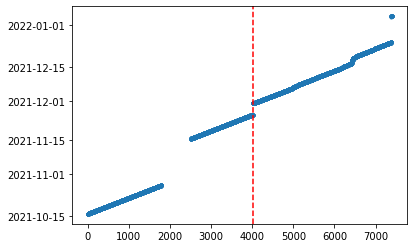

In [23]:
plt.plot(data_signal.index, data_signal.date, '.')
plt.axvline(x=TIME_INDEX_CUT, ls='--', c='r')

In [24]:
pd.options.mode.chained_assignment = None 
data_ = data_signal.loc[ (data_signal.temp>MIN_TEMP) & (data_signal.temp<MAX_TEMP)  & (data_signal.index>TIME_INDEX_CUT)]
X = (data_.date -  data_.date.to_numpy()[0]).astype('timedelta64[h]')/(365*24) #divides days into years

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  pedestal = 0.15 # FIXME
  data_[chan] = data_[chan] - pedestal #subtracts the pedestal value
  max_current = data_[chan][0:100].mean() 
  data_[chan] = data_[chan]/max_current#normalizing

<Figure size 432x288 with 0 Axes>

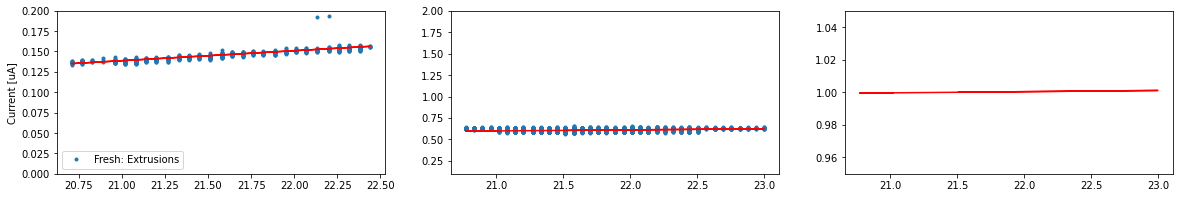

<Figure size 432x288 with 0 Axes>

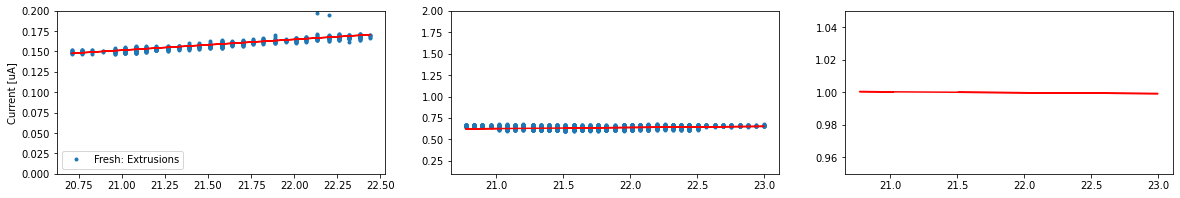

<Figure size 432x288 with 0 Axes>

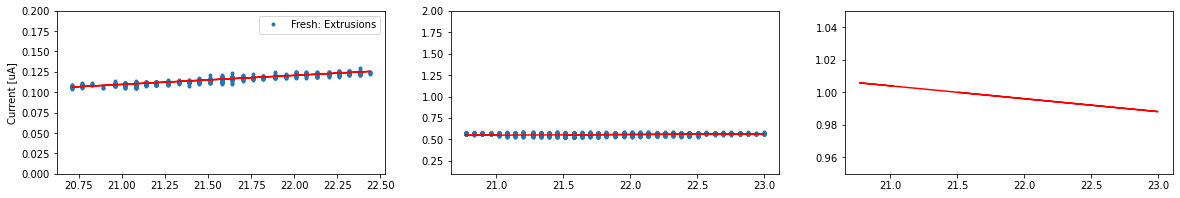

<Figure size 432x288 with 0 Axes>

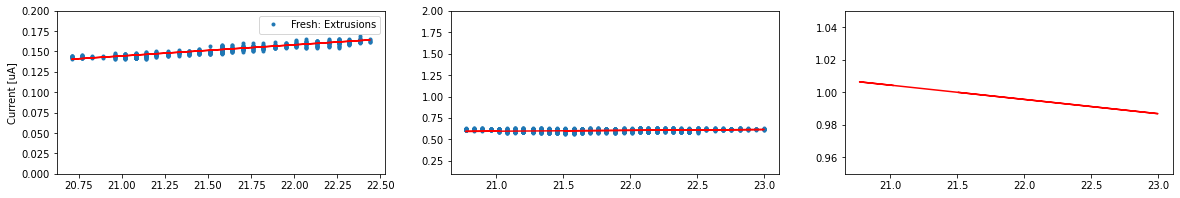

<Figure size 432x288 with 0 Axes>

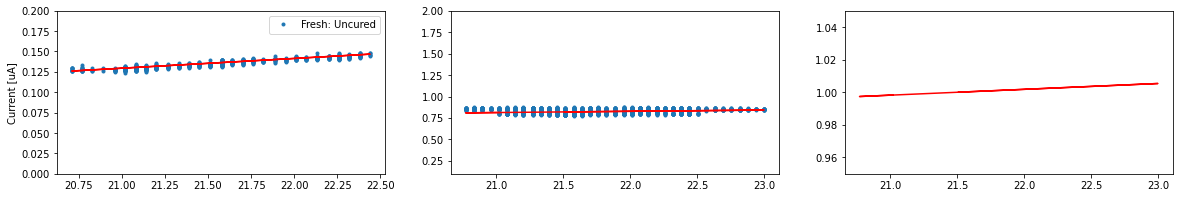

<Figure size 432x288 with 0 Axes>

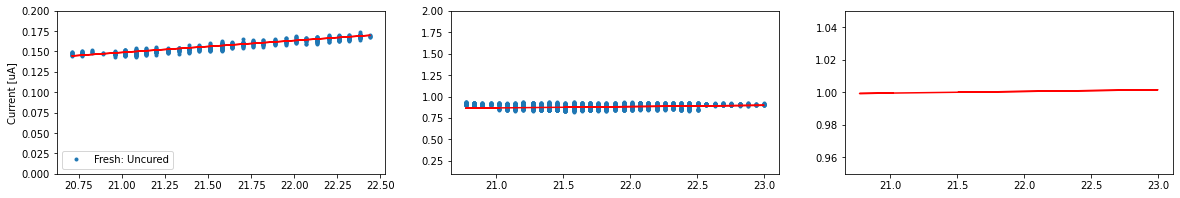

<Figure size 432x288 with 0 Axes>

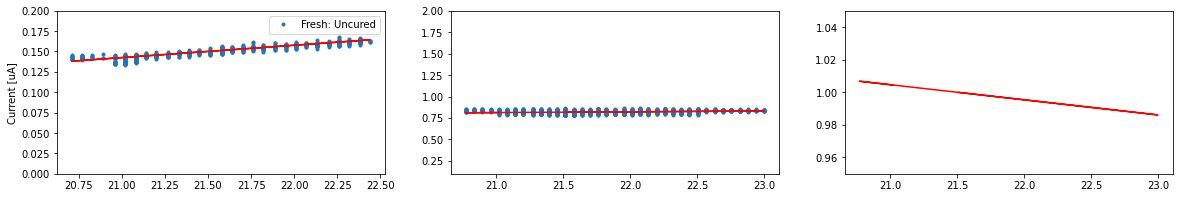

<Figure size 432x288 with 0 Axes>

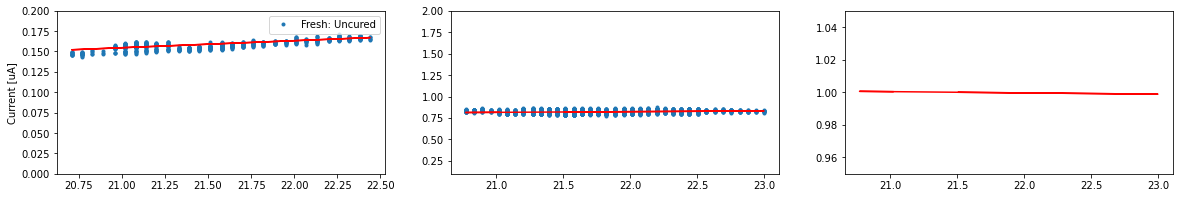

<Figure size 432x288 with 0 Axes>

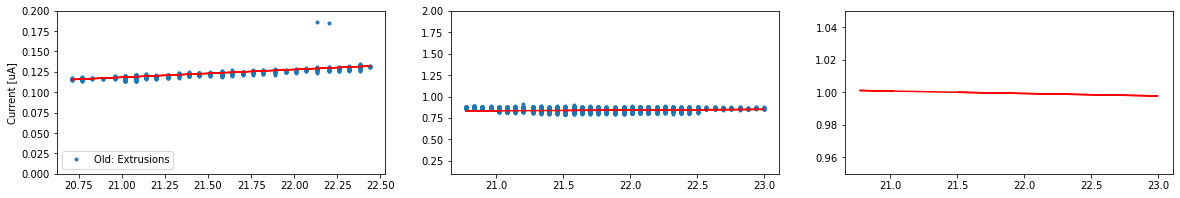

<Figure size 432x288 with 0 Axes>

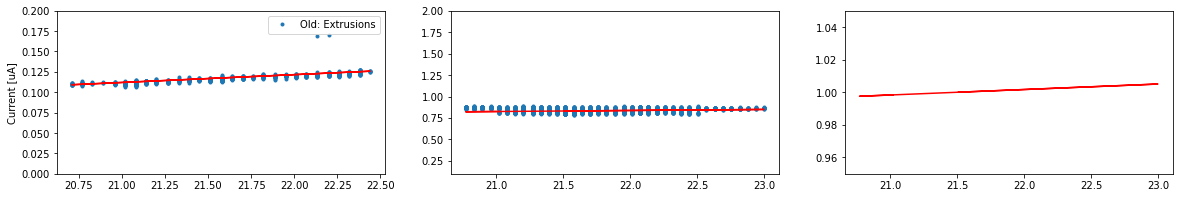

<Figure size 432x288 with 0 Axes>

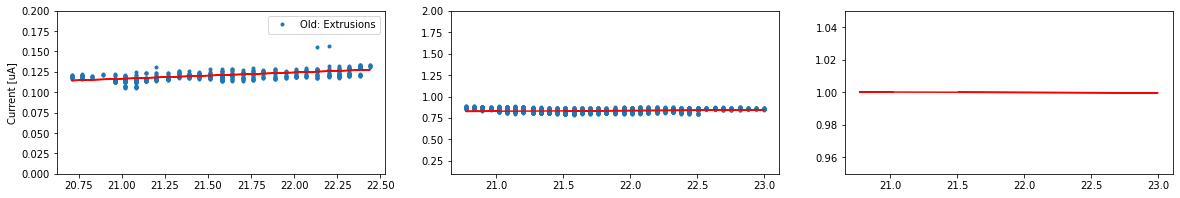

<Figure size 432x288 with 0 Axes>

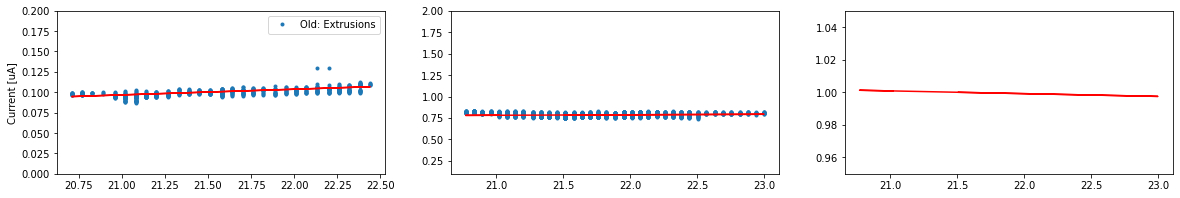

<Figure size 432x288 with 0 Axes>

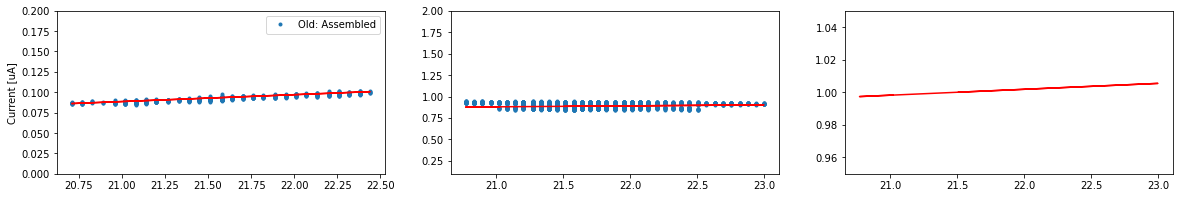

<Figure size 432x288 with 0 Axes>

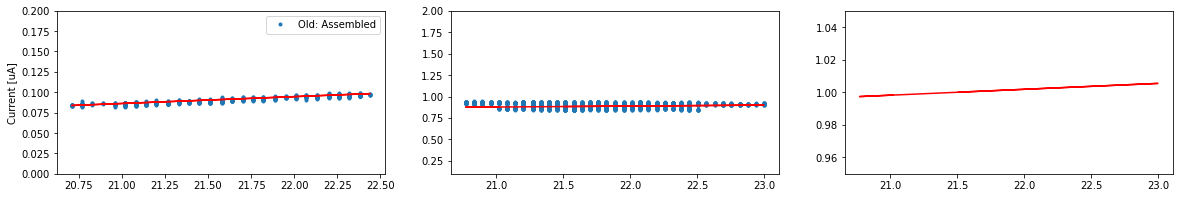

<Figure size 432x288 with 0 Axes>

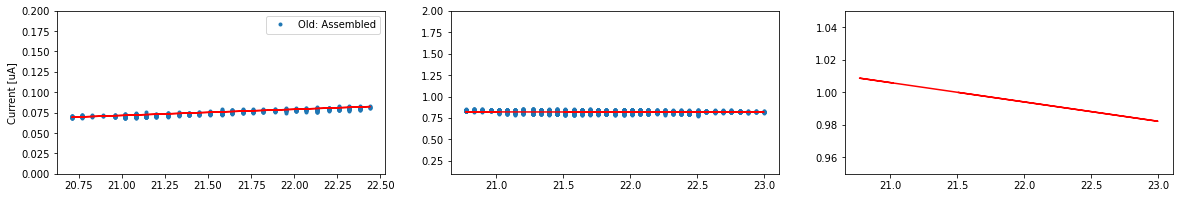

<Figure size 432x288 with 0 Axes>

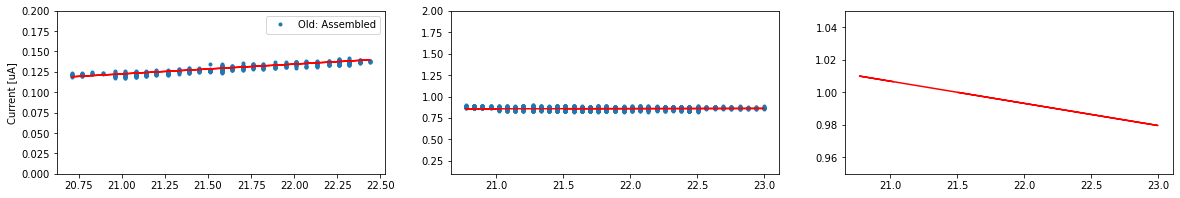

<Figure size 432x288 with 0 Axes>

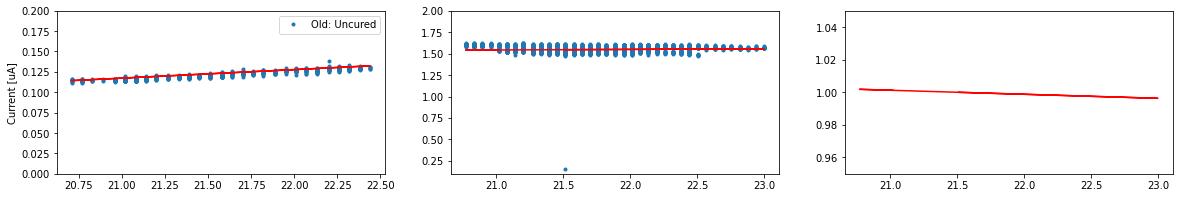

<Figure size 432x288 with 0 Axes>

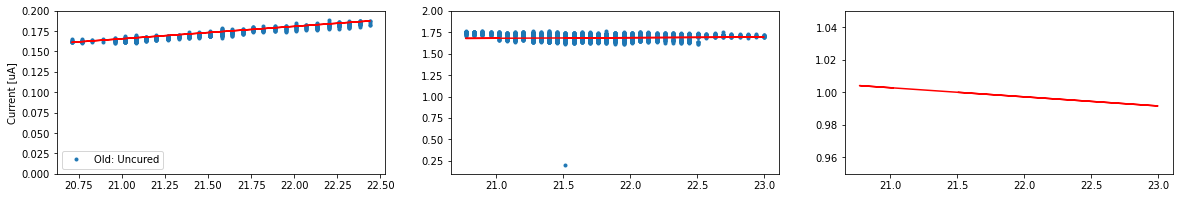

<Figure size 432x288 with 0 Axes>

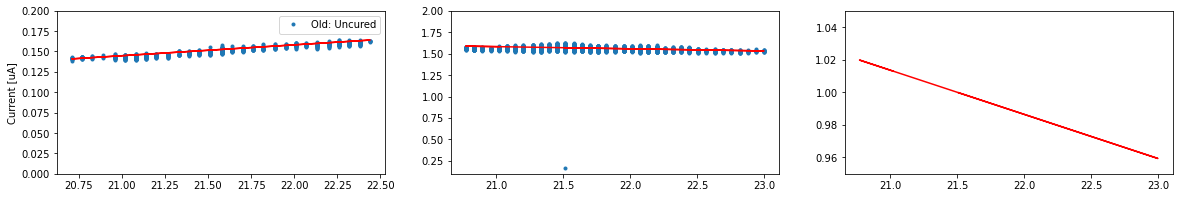

<Figure size 432x288 with 0 Axes>

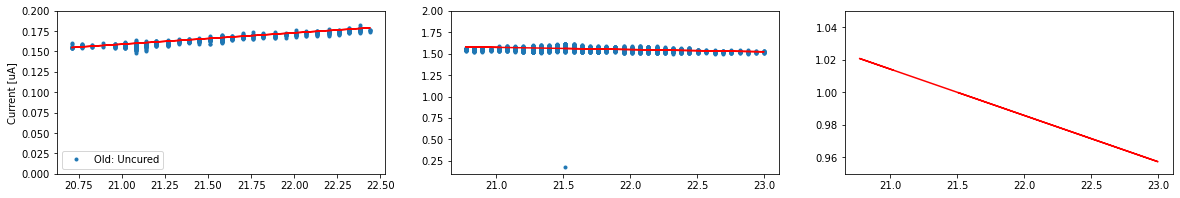

In [25]:
calib_df = pd.DataFrame()

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  plt.figure()

  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'

  fig, axs = plt.subplots(1,3, figsize=(20, 3));

  axs[0].plot(data_pedest.temp, data_pedest[chan], '.', label=label);
  popt_ped, pcov = curve_fit(lin_func, data_pedest.temp, data_pedest[chan], p0=(1, 0.05))
  axs[0].plot(data_pedest.temp, lin_func(data_pedest.temp, *popt_ped), 'r-')
  axs[0].set_ylabel('Current [uA]')
  axs[0].set_ylim(0.0, 0.2)
  axs[0].legend()

  axs[1].plot(data_signal.temp, data_signal[chan], '.', label=label);
  popt_sig, pcov = curve_fit(lin_func, data_signal.temp, data_signal[chan], p0=(1, 0.05))
  axs[1].plot(data_signal.temp, lin_func(data_signal.temp, *popt_sig), 'r-')
  axs[1].set_ylim(0.1, 2.)

  FIXED_TEMP = (MAX_TEMP+MIN_TEMP)/2
  SIG_AT_FIXED_TEMP = lin_func(FIXED_TEMP, *(popt_sig-popt_ped))
  axs[2].plot(data_signal.temp, lin_func(data_signal.temp, *(popt_sig-popt_ped))/SIG_AT_FIXED_TEMP, 'r-', label=label)
  axs[2].set_ylim(0.95, 1.05)
  calib_df = calib_df.append({'chan': chan,'name': label, 'const': (popt_sig-popt_ped)[0]/SIG_AT_FIXED_TEMP, 'slope': (popt_sig-popt_ped)[1]/SIG_AT_FIXED_TEMP}, ignore_index=True)

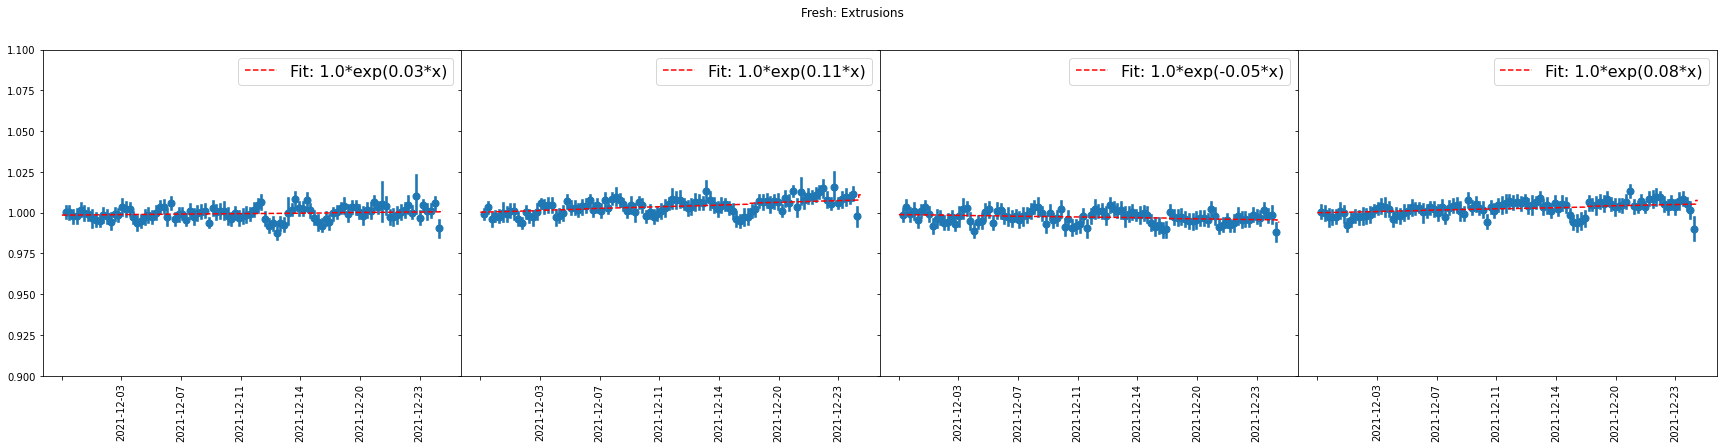

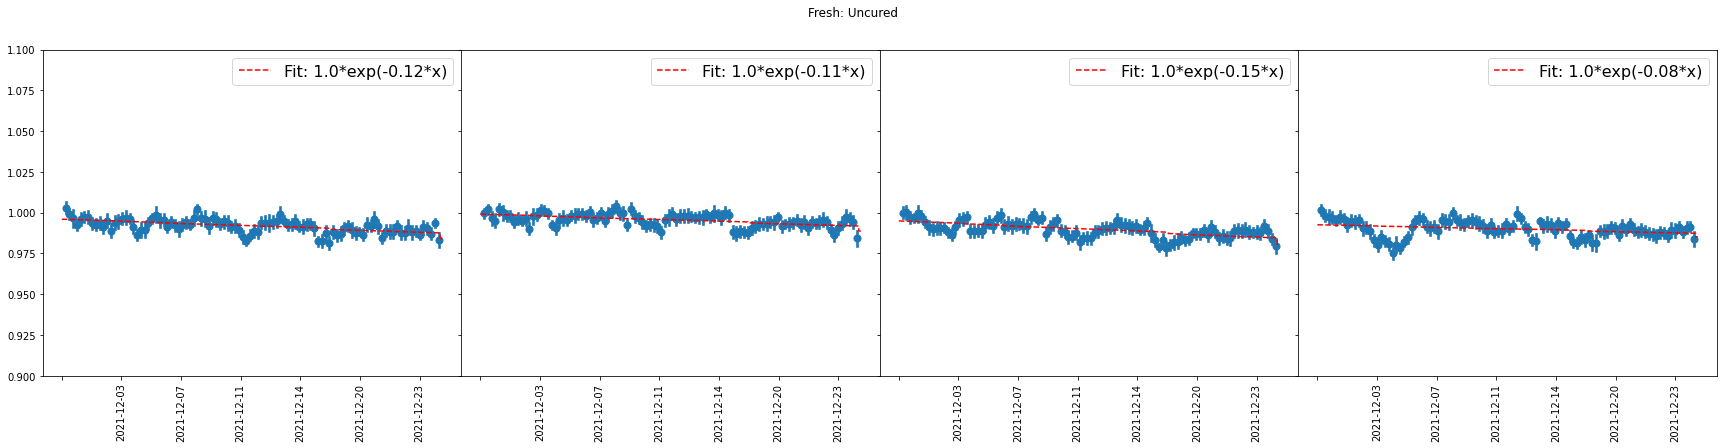

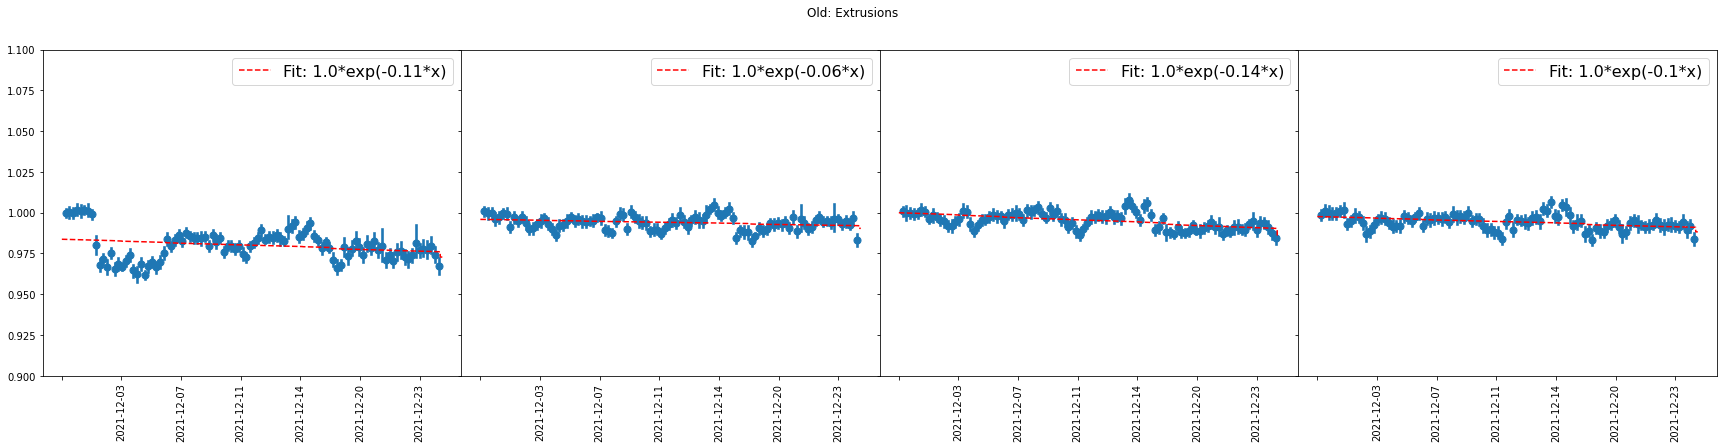

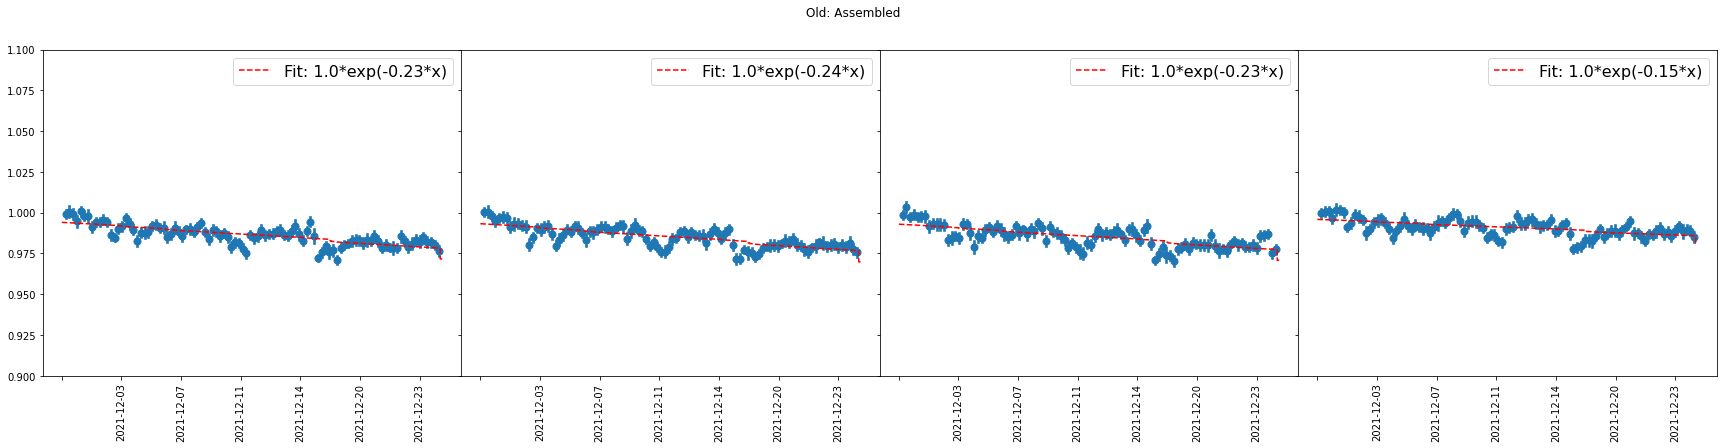

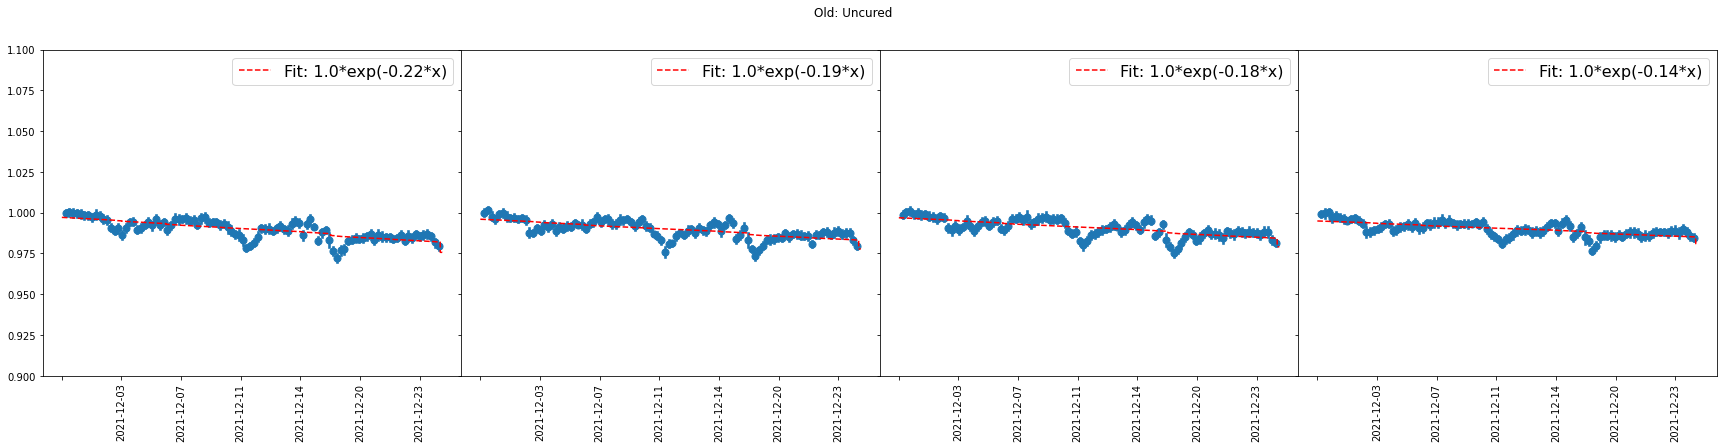

In [26]:
import seaborn as sns

data_['date_f'] = pd.factorize(data_['date'])[0] + 1
mapping = dict(zip(data_['date_f'], data_['date'].dt.date))

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):

  if(chan%4==0):
    fig, axs = plt.subplots(1,4, figsize=(30, 6), sharey=True);
    fig.subplots_adjust(wspace=0)

  y = data_[chan]
  y = y*np.exp(X*CS137_DECAY_RATE) #Cs137 decay rate: 2.3%/year
  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))

  ax=axs[chan%4]
  fig.suptitle(getChanLabel(chan))
  sns.regplot(x=data_['date_f'], y=y, x_bins=100, fit_reg=None, ax=ax)
  ax.plot(data_['date_f'], expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  ax.set_ylabel('')
  ax.set_xlabel('')
  labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
  ax.set_xticklabels(labels)
  ax.legend(loc='upper right', prop={'size': 16})
  ax.set_ylim(0.9,1.1)
  ax.tick_params(axis='x', labelrotation = 90);


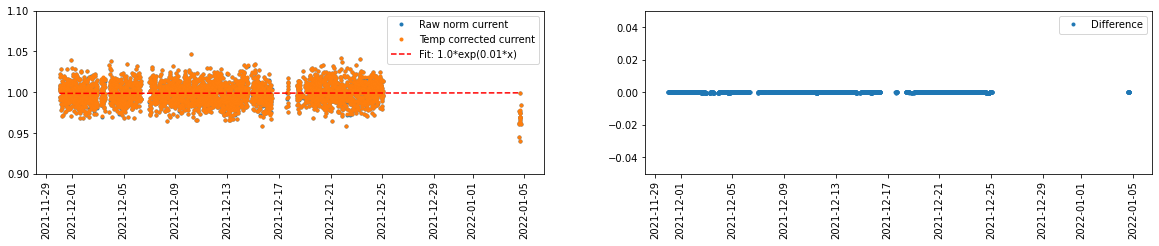

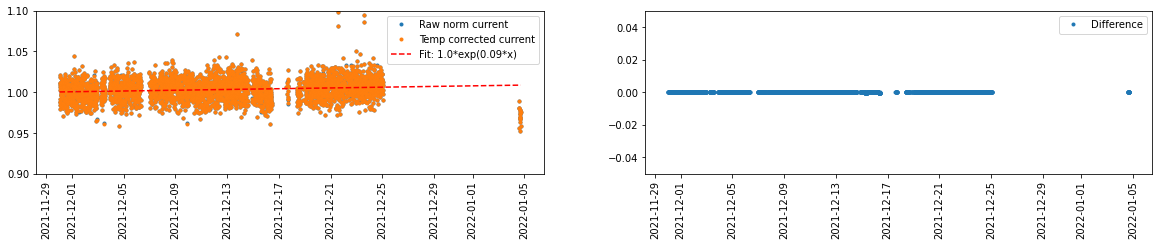

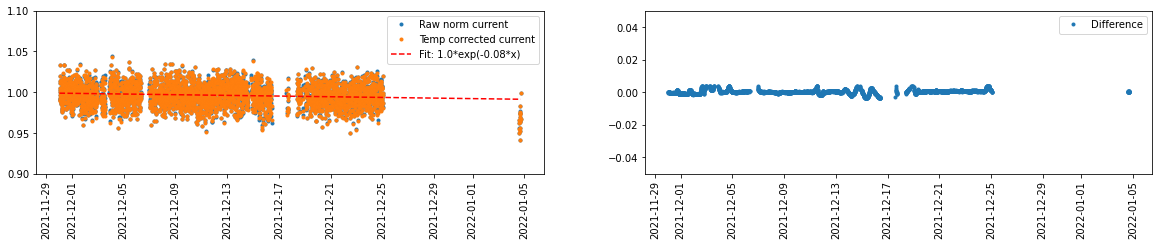

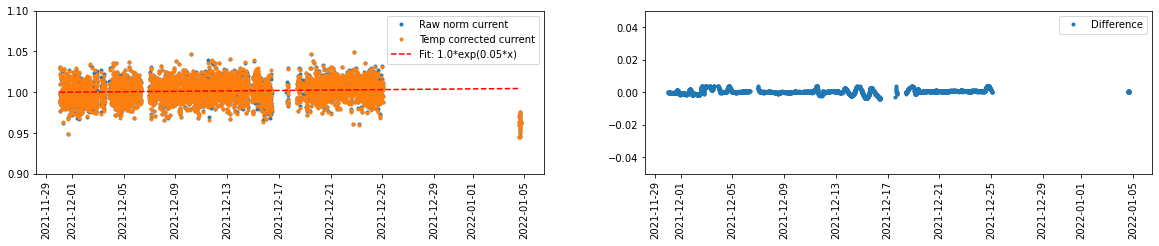

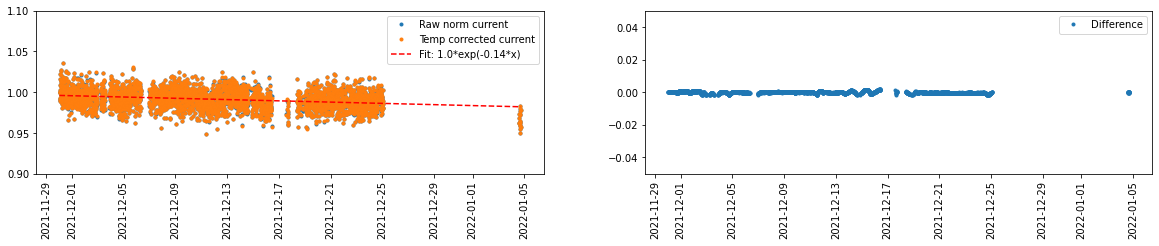

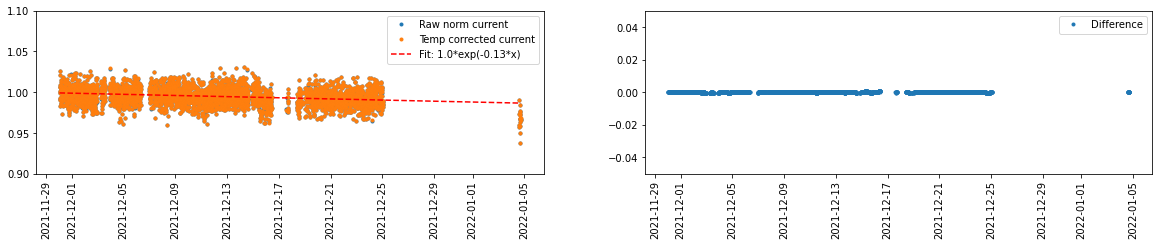

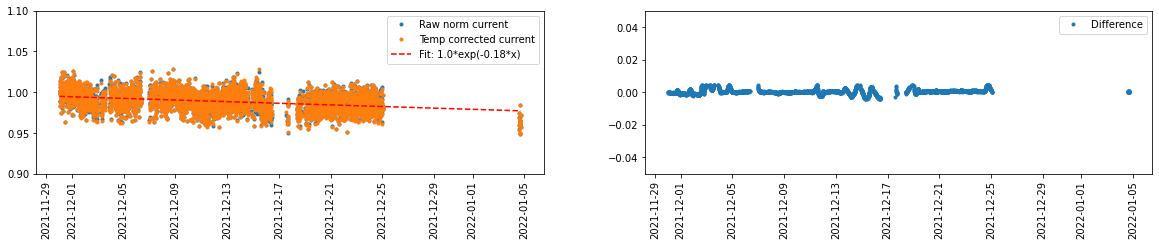

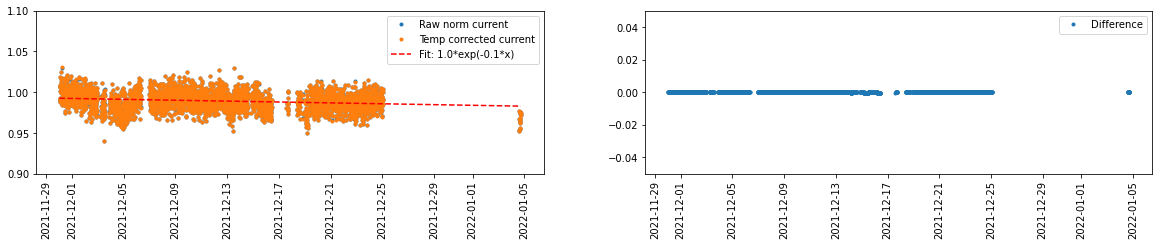

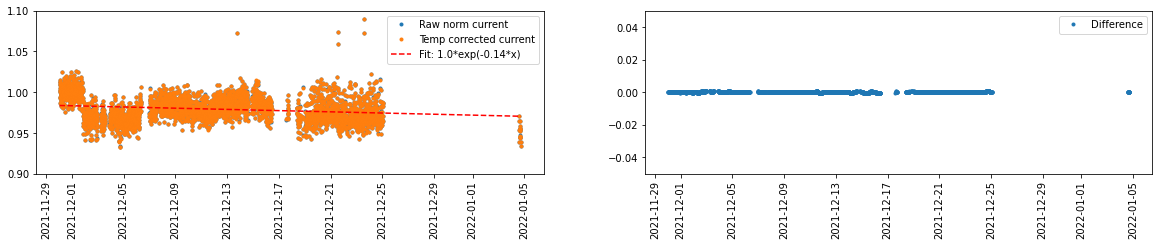

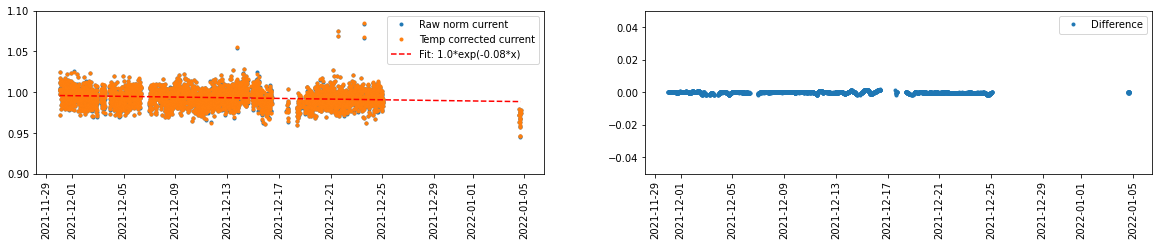

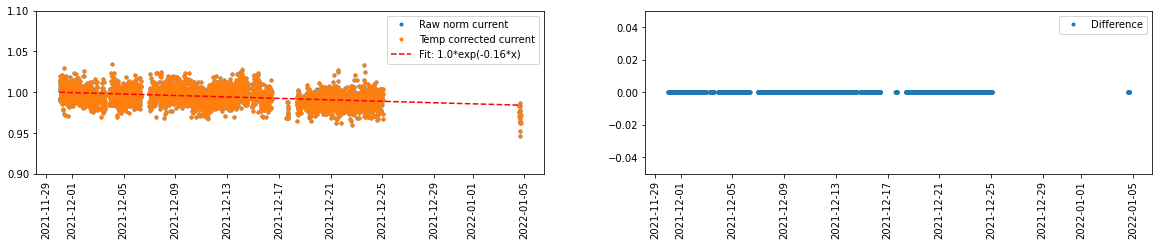

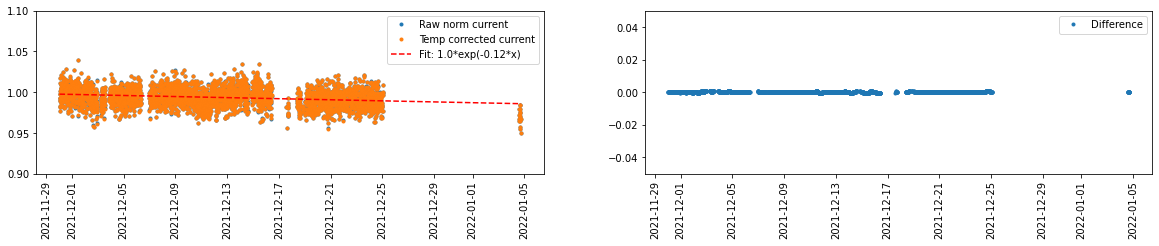

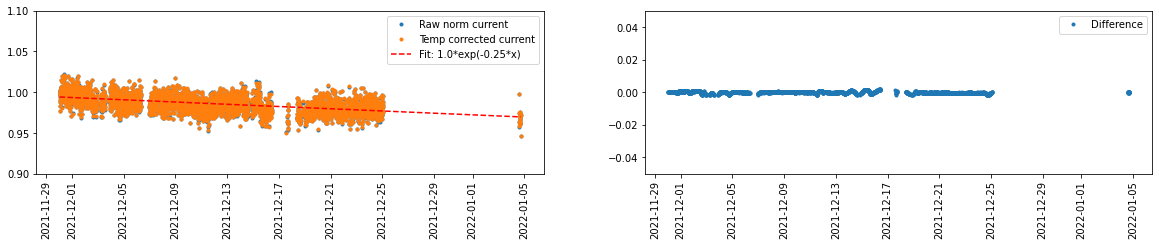

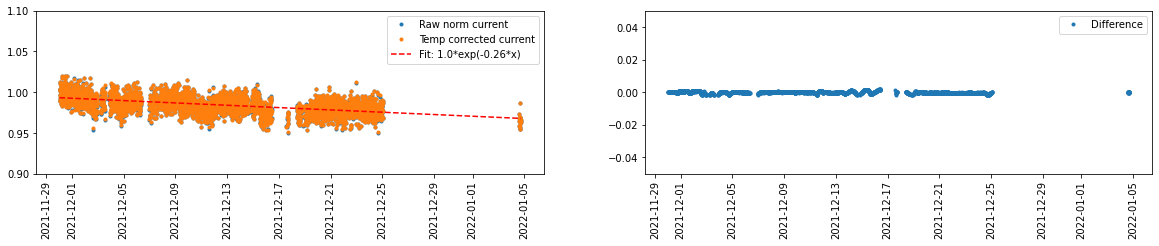

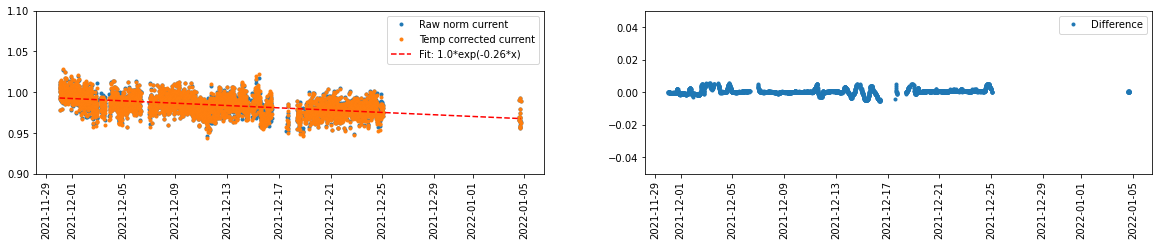

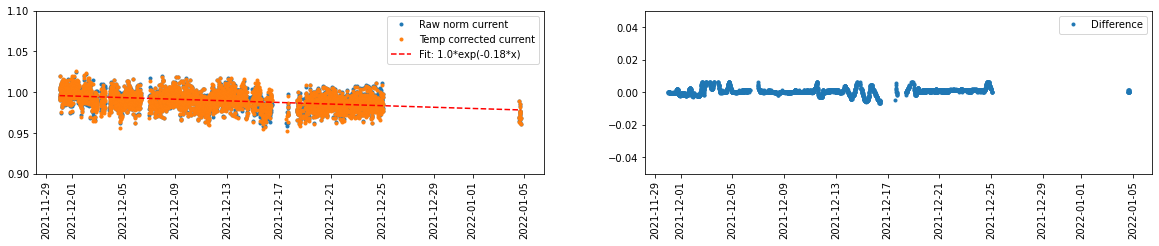

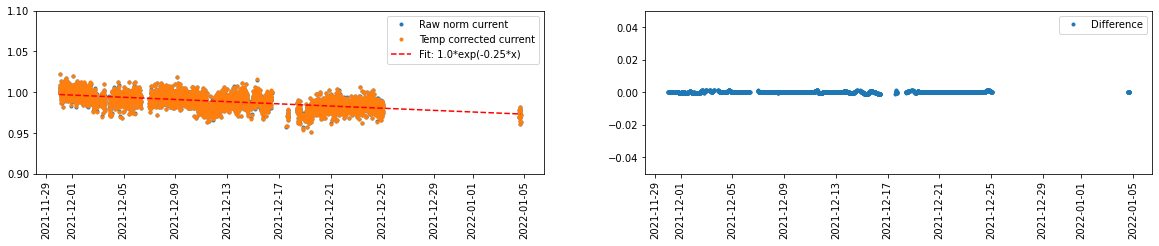

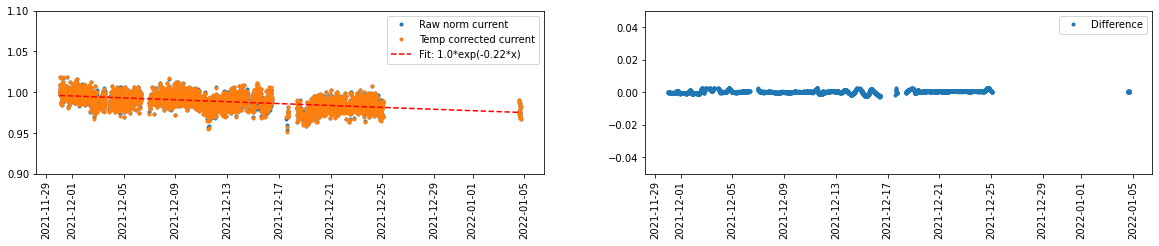

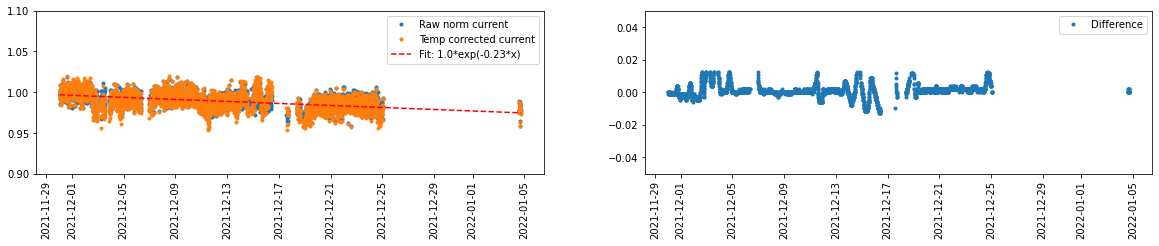

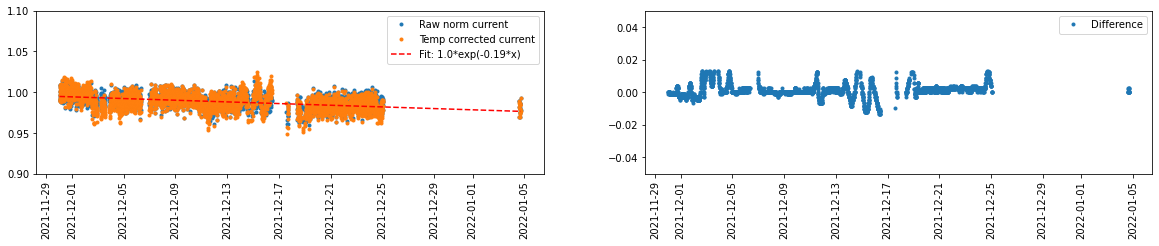

In [27]:
for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):

  fig, axs = plt.subplots(1,2, figsize=(20, 3));
  axs[0].plot(data_.date, data_[chan], '.', label='Raw norm current')

  y =  data_[chan]*(calib_df.query('chan==%d'%chan)['const'].to_numpy() + data_['temp']*calib_df.query('chan==%d'%chan)['slope'].to_numpy())
  axs[0].plot(data_.date, y, '.', label='Temp corrected current')
  axs[0].set_ylim(0.9, 1.1)
  axs[0].tick_params(axis='x', labelrotation = 90);
  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))
  axs[0].plot(data_.date, expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  axs[0].legend()


  axs[1].plot(data_.date, data_[chan] - data_[chan]*(calib_df.query('chan==%d'%chan)['const'].to_numpy() + data_['temp']*calib_df.query('chan==%d'%chan)['slope'].to_numpy()), '.', label='Difference')
  axs[1].set_ylim(-0.05, 0.05)
  axs[1].legend()
  axs[1].tick_params(axis='x', labelrotation = 90);


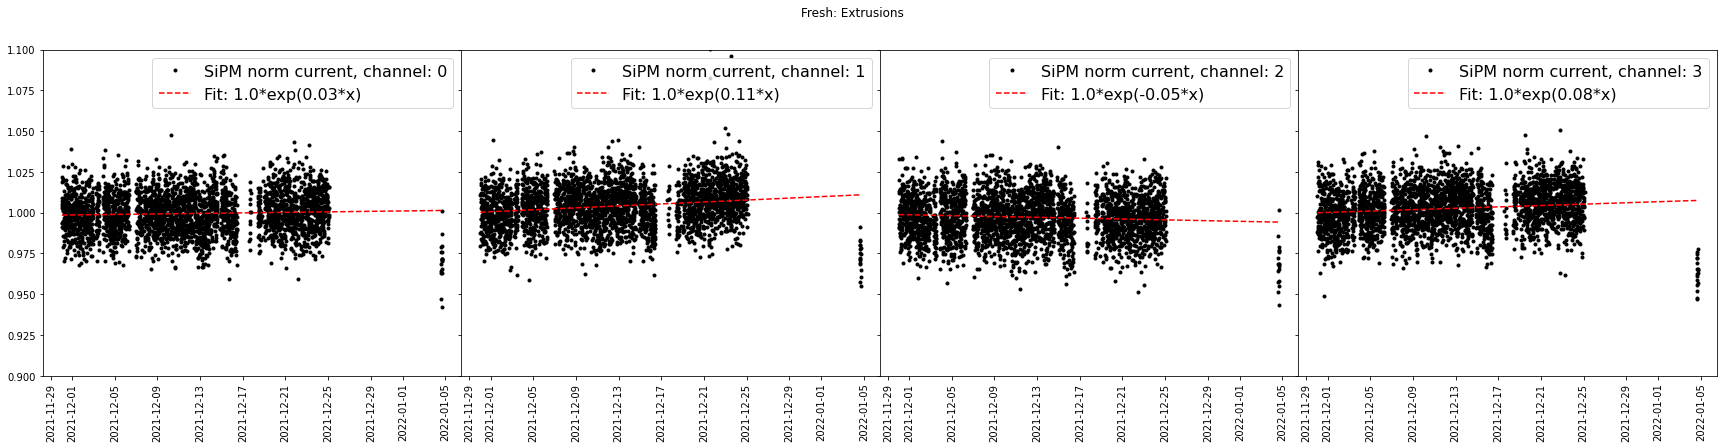

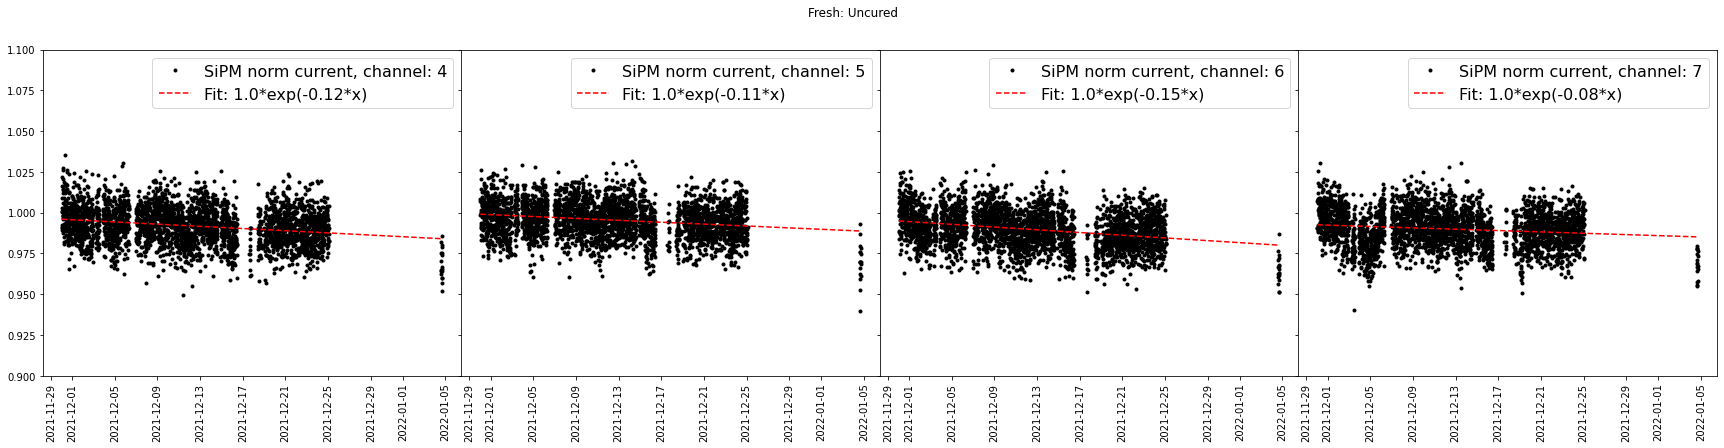

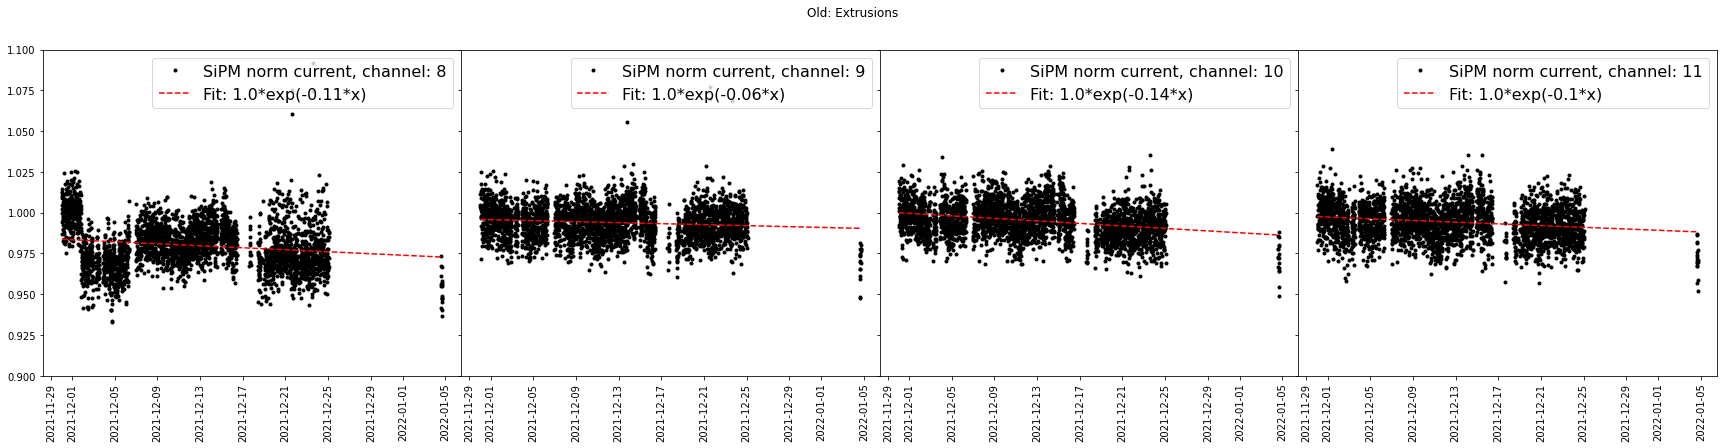

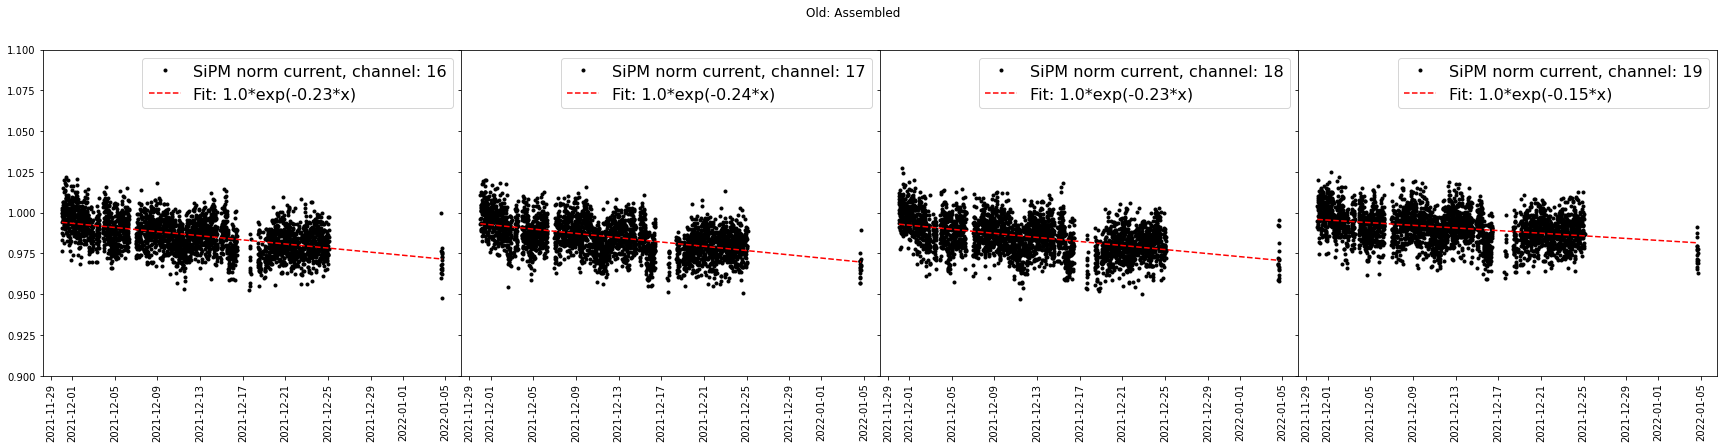

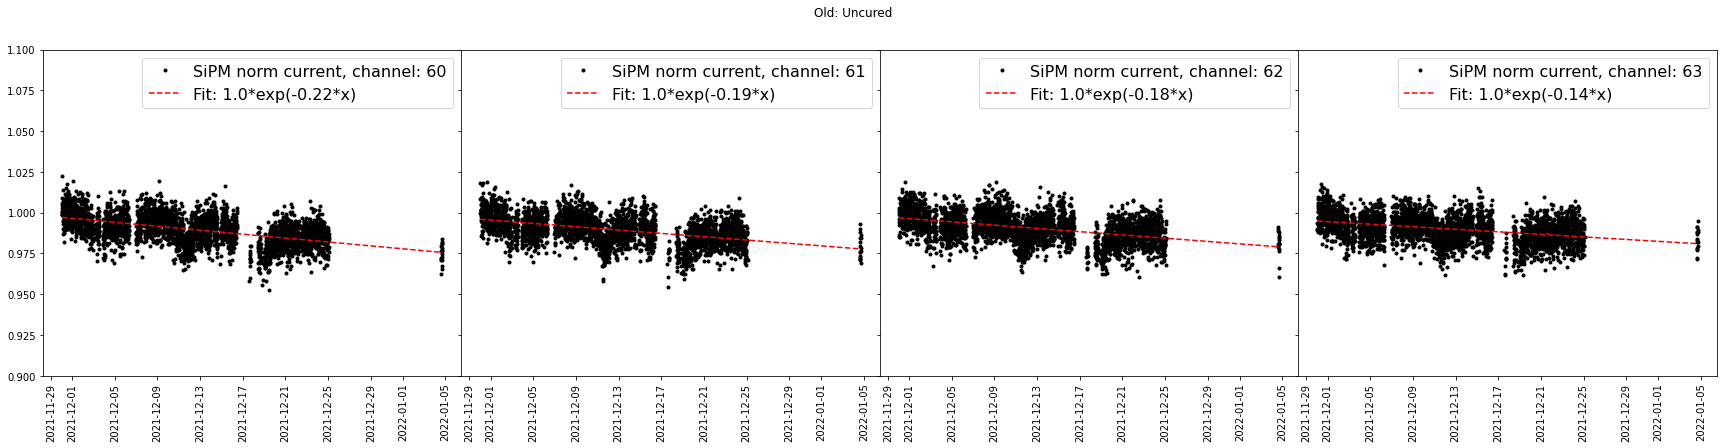

In [28]:
label = ''
for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  
  y = data_[chan]
  y = y*np.exp(X*CS137_DECAY_RATE) #Cs137 decay rate: 2.3%/year
  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))

  if(chan%4==0):
    fig, axs = plt.subplots(1,4, figsize=(30, 6), sharey=True);
    fig.subplots_adjust(wspace=0)
  fig.suptitle(getChanLabel(chan))
  axs[chan%4].plot(data_.date, y, 'k.', label="SiPM norm current, channel: %d"%chan);
  axs[chan%4].plot(data_.date, expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  axs[chan%4].legend(loc='upper right', prop={'size': 16})
  axs[chan%4].set_ylim(0.9,1.1);
  axs[chan%4].tick_params(axis='x', labelrotation = 90);

Text(0.5, 0, 'Temp [C]')

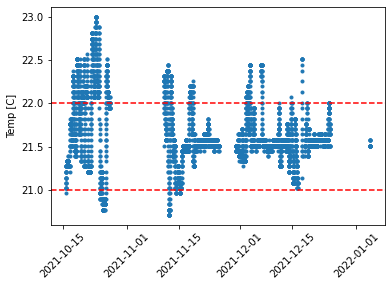

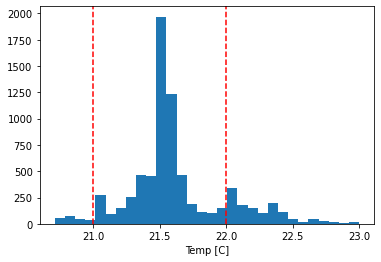

In [29]:
plt.plot(data.date, data.temp, '.', label='Temp [C]')
plt.axhline(y=MIN_TEMP, color='r', linestyle='--')
plt.axhline(y=MAX_TEMP, color='r', linestyle='--')
plt.xticks(rotation = 45);
plt.ylabel('Temp [C]')

plt.figure()
plt.hist(data.temp, bins=30, label='Temp [C]');
plt.axvline(x=MIN_TEMP, color='r', linestyle='--')
plt.axvline(x=MAX_TEMP, color='r', linestyle='--')
plt.xlabel('Temp [C]')

In [30]:
data[['date', 'source', 0, 'temp']].tail()

,date,source,0,temp
7392,2022-01-04 16:22:00,1,0.5684,21.51
7393,2022-01-04 16:32:00,1,0.5816,21.51
7394,2022-01-04 16:41:00,1,0.5948,21.51
7395,2022-01-04 16:50:00,1,0.5778,21.51
7396,2022-01-04 17:00:00,1,0.5883,21.51
